# Main analysis file

We load up one large dataframe consisting of all simulation sweeps and curves, produced by [src/get_all_data.py](../get_all_data.py).

In [45]:
import hydra
import torch

import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

## Load main dataframe

In [46]:
all_data_fp = "../../analysis_data/all_data.csv"

In [47]:
df = pd.read_csv(all_data_fp)
df

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_94670/2865108240.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.


,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
0,0.302817,0.285931,1.626097,10.196382,0.026481,-0.009173,0.749013,0.0,simulation,NaN,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
1,2.704773,1.499383,0.412644,9.724241,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
2,0.203795,0.189977,1.722051,11.818519,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
3,0.151592,0.142945,1.769083,12.727127,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
4,0.151410,0.143119,1.768909,12.660234,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,10,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160763,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160764,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160765,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
160766,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,100,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


## Set parameters for one theoretical bound

Using hydra compose overrides.

In [48]:
overrides = [
    # "game.universe=c1",

    # "game.universe=100",
    # "game.num_signals=100",

    "game.universe=2ball_300",
    "game.num_signals=300",

] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

curve_metadata = config.game

#### Meaning distributions

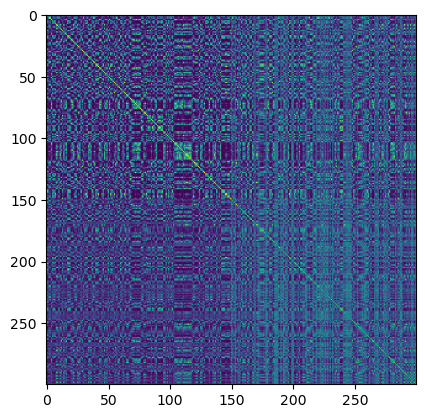

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

game = Game.from_hydra(config, cwd="/Users/nathanielimel/uci/projects/ibsg/data")
plt.imshow(game.meaning_dists)

#### helper function for subsetting

In [50]:
def get_df_subsetted_by_bound(df: pd.DataFrame, curve_metadata) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_gamma = df["meaning_dist_gamma"] == curve_metadata.meaning_dist_gamma

    bound_func = df["ib_bound_function"].isin([curve_metadata.ib_bound_function, torch.nan]) # check for 'embo', 'homebuilt' for curves, nan for all simulations since those are curve agnostic.

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_gamma & bound_func]

    return df_subsetted

### Subset dataframes for plotting

In [51]:
# visualize the curve!
df = get_df_subsetted_by_bound(df, curve_metadata)
df

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
29779,0.000000,0.000000,0.415825,1.451831,NaN,-0.000047,0.019987,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29780,7.410101,0.262093,0.153732,1.450953,NaN,NaN,NaN,1.0,trajectory,0.0,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29781,0.004072,0.001024,0.414801,1.451130,NaN,NaN,NaN,1.0,trajectory,1.0,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29782,0.000031,0.000010,0.415815,1.451824,NaN,NaN,NaN,1.0,trajectory,2.0,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
29783,0.000000,0.000000,0.415825,1.451831,NaN,NaN,NaN,1.0,trajectory,3.0,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,2.0,42.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158322,7.325103,NaN,NaN,0.002500,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,300,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
158323,7.327739,NaN,NaN,0.002486,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,300,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
158324,7.330357,NaN,NaN,0.002472,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,300,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo
158325,7.332965,NaN,NaN,0.002458,NaN,NaN,NaN,NaN,mse_bound,NaN,...,-8,300,squared_dist,NaN,0,NaN,NaN,NaN,NaN,embo


In [52]:
df_final_points = df[df["point_type"] == "simulation"]
df_curve_points = df[df["point_type"] == "ib_bound"]

### Plot

#### Trade-offs

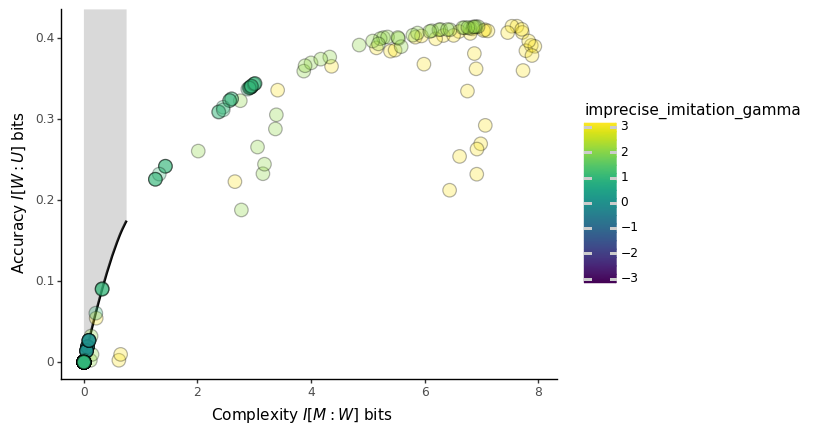

In [53]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            # fill="discriminative_need_gamma",
            fill="imprecise_imitation_gamma",
            # fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
)
print(plot)

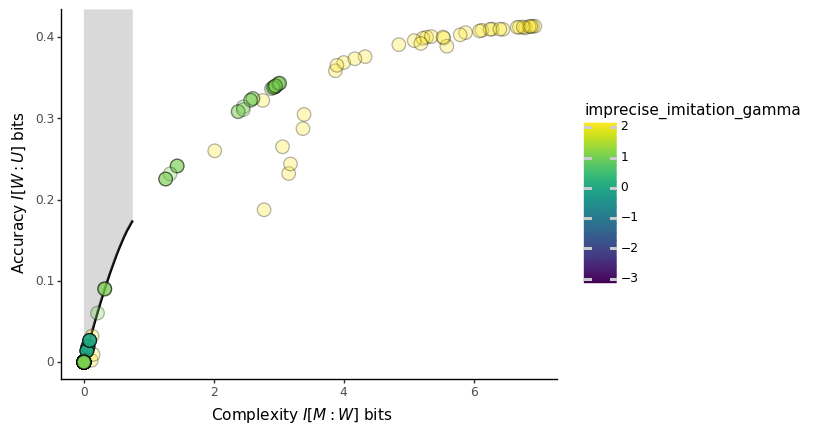

<ggplot: (356642492)>

In [69]:
# some scratch 
def plot_pressure_limits(pressure: str, pressure_limit: float) -> pn.ggplot:
    return (
        # Set data and the axes
        pn.ggplot(
            data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
        )  
        + pn.geom_line(size=1) # IB curve
        # + pn.geom_point(size=1)
        + pn.geom_ribbon(
        mapping=pn.aes(
            x="complexity",
            ymin="accuracy",
            ymax=torch.inf,
            ),
            fill="gray",
            alpha=0.3,
        )
        + pn.geom_point( # emergent langs
            data=df_final_points[df_final_points[pressure] <= pressure_limit],
            mapping=pn.aes(
                fill = pressure,
                ),
            alpha=0.3,
            size=5,
        )        
        + pn.xlab("Complexity $I[M:W]$ bits")
        + pn.ylab("Accuracy $I[W:U]$ bits")
        + pn.theme_classic()
    )
plot_pressure_limits(
    pressure="imprecise_imitation_gamma",
    pressure_limit=2,
)

### 3D plot of parameterspace

In [55]:
# todo. Matplotlib is so hacky and annoying.

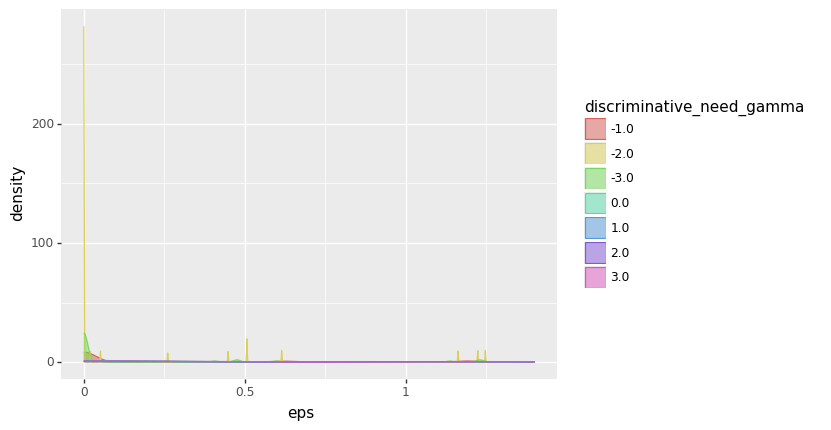

<ggplot: (362750055)>

In [70]:
# Easier: histogram of efficiency.
# efficiency loss = eps
df = df_final_points[df_final_points["eps"] > 0.]
df = df_final_points.copy()

pressure = "discriminative_need_gamma"
df[pressure] = [ str(item) for item in df[pressure].tolist()]

(
    pn.ggplot(data=df, mapping=pn.aes(x="eps", fill=pressure, color=pressure))
    + pn.geom_density(alpha=0.5)
)

##### Hold two of { discriminative_need, imprecise_imitation, population_init } fixed and vary the other

In [57]:
df_fixed = df_final_points[df_final_points["imprecise_imitation_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["population_init_gamma"] == -3.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
79684,0.000002,0.000000,0.415825,1.447391,NaN,6.388059e-05,0.029973,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
81098,0.062241,0.019016,0.396809,1.429171,0.014875,3.059514e-06,2.137158,0.0,simulation,NaN,...,-8,300,squared_dist,1.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
82512,0.000000,0.000000,0.415825,1.447885,NaN,7.365593e-07,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,-1.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
83926,0.000002,0.000000,0.415825,1.448016,NaN,1.149442e-04,0.016658,0.0,simulation,NaN,...,-8,300,squared_dist,-3.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
85299,0.045656,0.014044,0.401781,1.434265,0.009459,-1.539935e-04,2.070580,0.0,simulation,NaN,...,-8,300,squared_dist,3.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
86713,0.088428,0.026823,0.389002,1.421758,0.011430,-1.710279e-04,2.193749,0.0,simulation,NaN,...,-8,300,squared_dist,2.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
88127,0.000004,0.000000,0.415825,1.448004,NaN,1.914714e-04,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,-2.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN


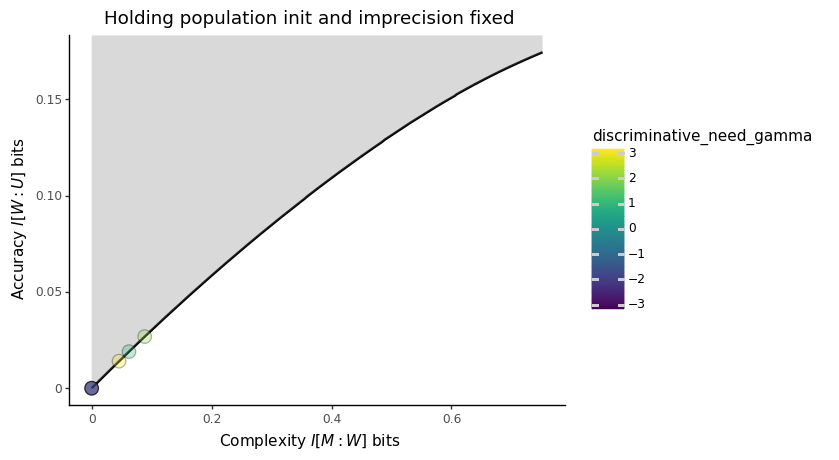

In [58]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding population init and imprecision fixed")
)
print(plot)

In [59]:
df_fixed = df_final_points[df_final_points["imprecise_imitation_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["discriminative_need_gamma"] == 0.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
78674,9.536743e-07,9.536743e-07,0.415824,1.447391,NaN,7.186168e-05,0.026644,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,2.0,42.0,NaN
78876,0.000000e+00,9.536743e-07,0.415824,1.447391,NaN,3.685196e-07,0.019987,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,3.0,42.0,NaN
79078,1.907349e-06,0.000000e+00,0.415825,1.447391,NaN,1.914714e-04,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,-1.0,42.0,NaN
79280,0.000000e+00,9.536743e-07,0.415824,1.447391,NaN,7.365593e-07,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,1.0,42.0,NaN
79482,0.000000e+00,0.000000e+00,0.415825,1.447391,NaN,7.365593e-07,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,0.0,42.0,NaN
79684,1.907349e-06,0.000000e+00,0.415825,1.447391,NaN,6.388059e-05,0.029973,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,-3.0,42.0,NaN
79886,0.000000e+00,0.000000e+00,0.415827,1.447391,NaN,7.186168e-05,0.026644,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,-2.0,42.0,NaN


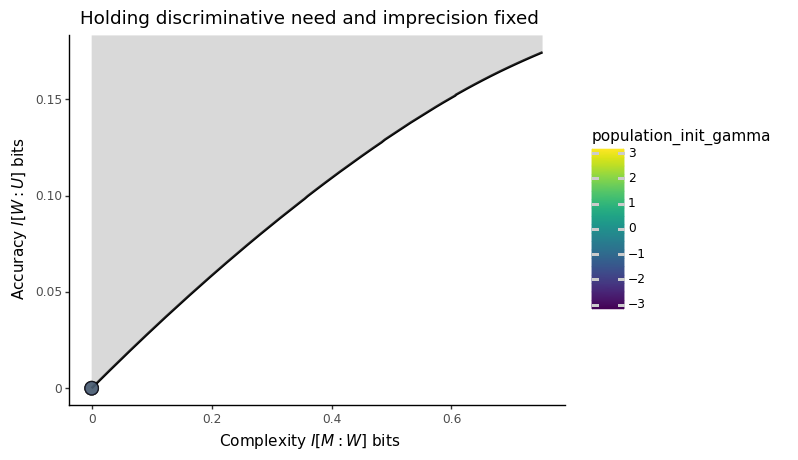

In [60]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="population_init_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding discriminative need and imprecision fixed")
)
print(plot)

In [61]:
df_fixed = df_final_points[df_final_points["population_init_gamma"] == 0.]
df_fixed = df_fixed[df_fixed["discriminative_need_gamma"] == 0.]
df_fixed

,complexity,accuracy,distortion,mse,gNID,eps,beta,run,point_type,round,...,prior,num_signals,distance,discriminative_need_gamma,meaning_dist_gamma,dynamics,imprecise_imitation_gamma,population_init_gamma,seed,ib_bound_function
30587,0.000002,0.000002,0.415823,1.451831,NaN,3.855521e-08,0.109867,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-1.0,0.0,42.0,NaN
40301,6.607974,0.407502,0.008323,1.157232,0.891098,1.129355e+00,5.000000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,3.0,0.0,42.0,NaN
50199,5.085898,0.395752,0.020073,1.162629,0.855195,8.272902e-01,5.000000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,2.0,0.0,42.0,NaN
60065,0.000000,0.000000,0.415827,1.452638,NaN,4.791562e-05,0.039960,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-2.0,0.0,42.0,NaN
69776,0.000000,0.000000,0.415825,1.452723,NaN,1.914714e-04,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,-3.0,0.0,42.0,NaN
79482,0.000000,0.000000,0.415825,1.447391,NaN,7.365593e-07,0.010000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,0.0,0.0,42.0,NaN
89339,1.327387,0.231784,0.184041,1.241049,0.367459,1.083823e-01,5.000000,0.0,simulation,NaN,...,-8,300,squared_dist,0.0,0,replicator_diffusion,1.0,0.0,42.0,NaN


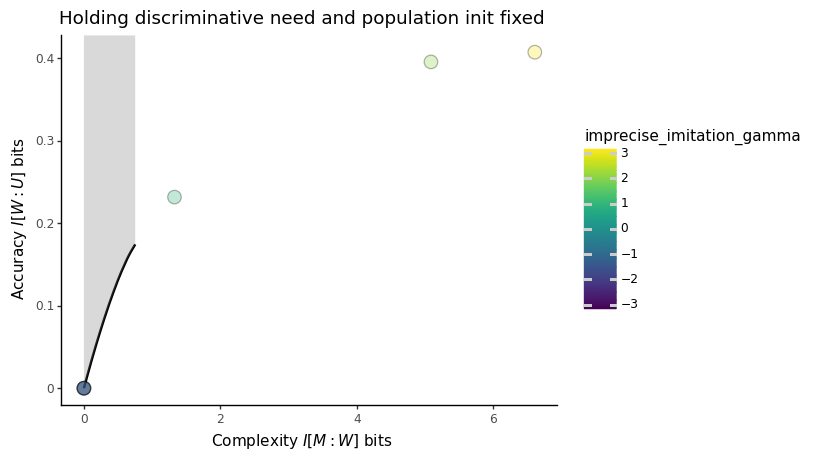

In [62]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_curve_points, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=1) # IB curve
    # + pn.geom_point(size=1)
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=torch.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_fixed,
        mapping=pn.aes(
            fill="imprecise_imitation_gamma",
            ),
        alpha=0.3,
        size=5,
    )        
    + pn.xlab("Complexity $I[M:W]$ bits")
    + pn.ylab("Accuracy $I[W:U]$ bits")
    + pn.theme_classic()
    + pn.ggtitle(f"Holding discriminative need and population init fixed")
)
print(plot)